In [1]:
import os
import random
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras. layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [2]:
# Specify the paths to the directories containing the images
non_COVID = r'C:\Users\karip\OneDrive\PC\Centre\University\Classes\Digital Processing of Biosignals\Assignments\COVID 19 Detection using AL and CNN\Dataset\non-COVID'
COVID = r'C:\Users\karip\OneDrive\PC\Centre\University\Classes\Digital Processing of Biosignals\Assignments\COVID 19 Detection using AL and CNN\Dataset\COVID'

In [3]:
# Set the batch size and epochs for training
batch_size = 16
epochs = 10

# Set the number of uncertain instances to select in each active learning iteration
n_uncertain = 5

# Initialize lists to store the images and labels
images = []
labels = []

In [4]:
# Load the images and labels from the non-COVID and COVID directories
for image_dir, label in [(non_COVID, 0), (COVID, 1)]:
    filenames = os.listdir(image_dir)
    for filename in filenames:
        img = Image.open(os.path.join(image_dir, filename))
        img = img.convert('L')
        img = img.resize((64, 64))        
        img = np.array(img)
        img = img / 255
        img = np.expand_dims(img, 2)
        images.append(img)
        labels.append(label)

In [5]:
# Convert the images and labels to numpy arrays
images = np.array(images)
labels = np.array(labels)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [77]:
# Create the train, validation, and test datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).shuffle(buffer_size=len(X_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

In [79]:
print(f'Number of samples in each set (train, val, test): {len(y_train), len(y_val), len(y_test)}')
print(f'Number of positive samples in each set: {y_train.sum(), y_val.sum(), y_test.sum()}')
print(len(y_train)+len(y_val)+len(y_test))
print(len(train_ds) * 16, len(val_ds) * 16, len(test_ds) * 16)

Number of samples in each set (train, val, test): (1587, 397, 497)
Number of positive samples in each set: (797, 196, 259)
2481
1600 400 512


In [9]:
# Initialize the model
model = Sequential()

# Add convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the feature maps
model.add(Flatten())

# Add a fully connected layer
model.add(Dense(128, activation='relu'))

# Add an output layer with a single node and sigmoid activation function
model.add(Dense(1, activation='sigmoid'))

In [10]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5)

Epoch 1/5
50/50 [==============================] - 7s 108ms/step - loss: 0.6649 - accuracy: 0.5967 - val_loss: 0.5439 - val_accuracy: 0.7203
Epoch 2/5
50/50 [==============================] - 5s 101ms/step - loss: 0.5300 - accuracy: 0.7454 - val_loss: 0.4705 - val_accuracy: 0.7686
Epoch 3/5
50/50 [==============================] - 5s 101ms/step - loss: 0.5256 - accuracy: 0.7505 - val_loss: 0.4827 - val_accuracy: 0.7767
Epoch 4/5
50/50 [==============================] - 5s 101ms/step - loss: 0.4145 - accuracy: 0.8091 - val_loss: 0.4625 - val_accuracy: 0.7787
Epoch 5/5
50/50 [==============================] - 5s 100ms/step - loss: 0.3779 - accuracy: 0.8248 - val_loss: 0.3591 - val_accuracy: 0.8370


25/25 [==============================] - 1s 20ms/step - loss: 0.3444 - accuracy: 0.8463


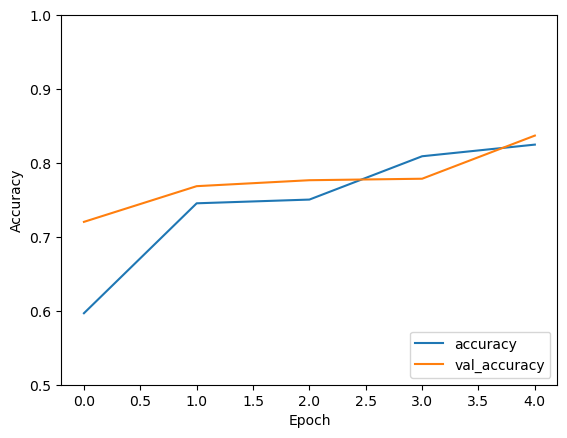

In [12]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

loss, accuracy = model.evaluate(val_ds)

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

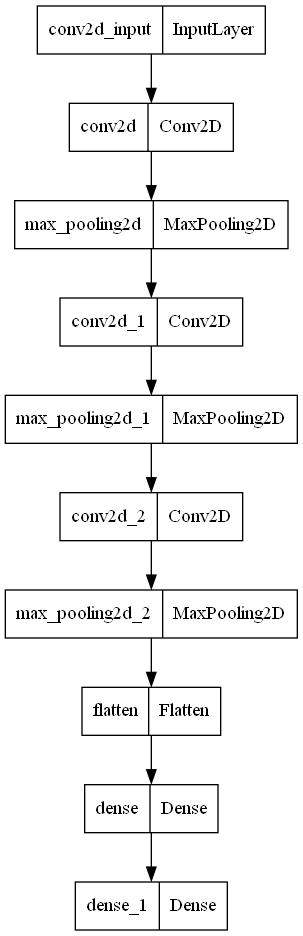

In [14]:
# print(X_test.shape)
# print(X_test[0][0][0])
# results = model.predict(X_test)
# print(results.shape)
tf.keras.utils.plot_model(model)

In [15]:
def select_uncertain(model, images, labels):
    # Get the model's predictions for the images
    predictions = model.predict(images)
    
    # Initialize lists to store the selected images and labels
    selected_images = []
    selected_labels = []
    
    # Iterate over the images and labels
    for image, label, prediction in zip(images, labels, predictions):
        # Calculate the absolute difference between the prediction and the label
        difference = abs(prediction - label)
        
        # If the difference is greater than a certain threshold, add the image and label to the selected lists
        if difference > 0.5:
            selected_images.append(image)
            selected_labels.append(label)
    
    # Return the selected images and labels
    return selected_images, selected_labels

In [32]:
val_acc_for = []
train_acc_for = []

# Loop until there are no more uncertain instances
while True:
    # Select a batch of uncertain instances
    uncertain_images, uncertain_labels = select_uncertain(model, images, labels)
    
    # Break the loop if there are no more uncertain instances
    if len(uncertain_images) == 0:
        break
    
    # Take the first n_uncertain instances
    uncertain_images = uncertain_images[:n_uncertain]
    uncertain_labels = uncertain_labels[:n_uncertain]
    
    # Add the uncertain instances to the training dataset
    train_ds = train_ds.concatenate(tf.data.Dataset.from_tensor_slices((uncertain_images, uncertain_labels)).batch(batch_size))
    
    # Shuffle the training dataset
    train_ds = train_ds.shuffle(buffer_size=len(X_train))
    
    # Train the model on the updated training dataset
    history = model.fit(train_ds, epochs=2, validation_data=val_ds)
    # print(history.history)
    
    # Get the training and validation accuracy and loss for each epoch
    accuracies = history.history['accuracy']
    val_accuracies = history.history['val_accuracy']
    losses = history.history['loss']
    val_losses = history.history['val_loss']
    
    for acc1 in accuracies:
        train_acc_for.append(acc1)
    
    for acc2 in val_accuracies:
        val_acc_for.append(acc2)

    # Initialize a figure with 2 subplots
    #fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the training and validation accuracy curves on the first subplot
    #ax[0].plot(accuracies)
    #ax[0].plot(val_accuracies)
    #ax[0].set_title('Model accuracy')
    #ax[0].set_ylabel('Accuracy')
    #ax[0].set_xlabel('Epoch')
    #ax[0].legend(['Training', 'Validation'], loc='upper left')

    # Plot the training and validation loss curves on the second subplot
    #ax[1].plot(losses)
    #ax[1].plot(val_losses)
    #ax[1].set_title('Model loss')
    #ax[1].set_ylabel('Loss')
    #ax[1].set_xlabel('Epoch')
    #ax[1].legend(['Training', 'Validation'], loc='upper left')

    #plt.show()

78/78 [==============================] - 2s 28ms/step
Epoch 1/2
108/108 [==============================] - 7s 60ms/step - loss: 0.1493 - accuracy: 0.9508 - val_loss: 0.1794 - val_accuracy: 0.9320
Epoch 2/2
78/78 [==============================] - 2s 25ms/step
Epoch 1/2
109/109 [==============================] - 7s 60ms/step - loss: 0.1094 - accuracy: 0.9706 - val_loss: 0.1566 - val_accuracy: 0.9421
Epoch 2/2
78/78 [==============================] - 2s 26ms/step
Epoch 1/2
110/110 [==============================] - 7s 60ms/step - loss: 0.0833 - accuracy: 0.9633 - val_loss: 0.1756 - val_accuracy: 0.9345
Epoch 2/2
78/78 [==============================] - 2s 25ms/step
Epoch 1/2
111/111 [==============================] - 7s 60ms/step - loss: 0.0227 - accuracy: 0.9915 - val_loss: 0.3219 - val_accuracy: 0.8917
Epoch 2/2
78/78 [==============================] - 2s 25ms/step
Epoch 1/2
112/112 [==============================] - 7s 60ms/step - loss: 0.0723 - accuracy: 0.9781 - val_loss: 0.1986 - v

KeyboardInterrupt: 

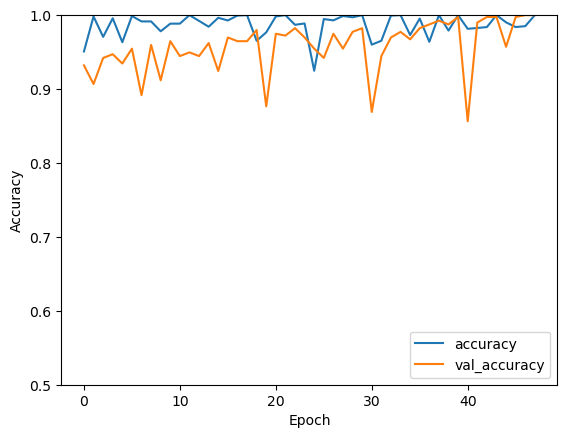

In [33]:
# Plot the training and validation loss
# plt.plot(losses_for)
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Val'], loc='upper left')
# plt.show()

plt.plot(train_acc_for, label='accuracy')
plt.plot(val_acc_for, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [34]:
# history.history['loss']\
history.history

{'loss': [0.04199229180812836, 0.0036478203255683184],
 'accuracy': [0.9850660562515259, 1.0],
 'val_loss': [0.01618969812989235, 0.00814426876604557],
 'val_accuracy': [1.0, 1.0]}

In [36]:
# Evaluate the model on the val dataset
loss, accuracy = model.evaluate(val_ds)

print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')

25/25 [==============================] - 1s 24ms/step - loss: 0.0065 - accuracy: 1.0000
Test loss: 0.0065
Test accuracy: 1.0000


In [35]:
# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(test_ds)

print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')

32/32 [==============================] - 1s 24ms/step - loss: 0.0063 - accuracy: 1.0000
Test loss: 0.0063
Test accuracy: 1.0000


In [59]:
for i in range(1, 12):
    ##### Load the image
    image_path = r'C:\Users\karip\OneDrive\PC\Centre\University\Classes\Digital Processing of Biosignals\Assignments\COVID 19 Detection using AL and CNN\My Evaluation\\' + f'{i} - normal.jpg' 
    image = Image.open(image_path)

    # Preprocess the image
    image = image.convert('L')
    image = image.resize((64, 64))
    image = np.array(image)

    # Reshape the image to match the model's input shape
    image = image.reshape(1, 64, 64, 1)

    # Get the model's prediction
    prediction = model.predict(image)[0]

    # Print the prediction
    if prediction > 0.5:
        print('COVID')
    else:
        print('non-COVID')

    # Print the probability of the prediction
    print(prediction)


1/1 [==============================] - 0s 45ms/step
COVID
[1.]
1/1 [==============================] - 0s 47ms/step
COVID
[1.]
1/1 [==============================] - 0s 47ms/step
non-COVID
[0.]
1/1 [==============================] - 0s 51ms/step
COVID
[1.]
1/1 [==============================] - 0s 44ms/step
non-COVID
[0.]
1/1 [==============================] - 0s 45ms/step
non-COVID
[0.]
1/1 [==============================] - 0s 57ms/step
COVID
[1.]
1/1 [==============================] - 0s 59ms/step
COVID
[1.]
1/1 [==============================] - 0s 47ms/step
COVID
[1.]
1/1 [==============================] - 0s 51ms/step
COVID
[1.]
1/1 [==============================] - 0s 46ms/step
non-COVID
[0.]


In [60]:
for i in range(1, 12):
    ##### Load the image
    image_path = r'C:\Users\karip\OneDrive\PC\Centre\University\Classes\Digital Processing of Biosignals\Assignments\COVID 19 Detection using AL and CNN\My Evaluation\\' + f'{i} - covid.jpg' 
    image = Image.open(image_path)

    # Preprocess the image
    image = image.convert('L')
    image = image.resize((64, 64))
    image = np.array(image)

    # Reshape the image to match the model's input shape
    image = image.reshape(1, 64, 64, 1)

    # Get the model's prediction
    prediction = model.predict(image)[0]

    # Print the prediction
    if prediction > 0.5:
        print('COVID')
    else:
        print('non-COVID')

    # Print the probability of the prediction
    print(prediction)


1/1 [==============================] - 0s 48ms/step
COVID
[1.]
1/1 [==============================] - 0s 48ms/step
non-COVID
[0.]
1/1 [==============================] - 0s 54ms/step
COVID
[1.]
1/1 [==============================] - 0s 57ms/step
COVID
[1.]
1/1 [==============================] - 0s 55ms/step
COVID
[1.]
1/1 [==============================] - 0s 57ms/step
COVID
[1.]
1/1 [==============================] - 0s 52ms/step
COVID
[1.]
1/1 [==============================] - 0s 47ms/step
COVID
[1.]
1/1 [==============================] - 0s 65ms/step
COVID
[1.]
1/1 [==============================] - 0s 50ms/step
COVID
[1.]
1/1 [==============================] - 0s 46ms/step
COVID
[1.]
